<div class="alert alert-success">
<h3> Will be transated...</h3>

</div>

## Создание инструмента определения токсичных комментариев пользователей нового сервиса интернет-магазина «Викишоп».
---
В исследовании рассмотрены модели классификации текстов, определяющие токсичность текста комментария.

---
#### Описание данных
Признак:

- text — текст комментария.

Целевой признак:
- toxic - токсичность комментария.

---
<a id='the_contents'></a>
#### Исследование состоит из 3 частей.

##### Часть 1. Подготовка.
* [1.1 Импорт библиотек.](#the_part_1.1)
* [1.2 Загрузка файла.](#the_part_1.2)
* [1.3 Изучение общей информации.](#the_part_1.3)
* [1.4 Обработка пропущенных значений и дубликатов.](#the_part_1.4)

##### Часть 2. Обучение моделей.
* [2.1 Лемматизация и подготовка данных для обучения.](#the_part_2.1)
* [2.2 Линейный метод опорных векторов.](#the_part_2.2)
* [2.3 Логистическая регрессия.](#the_part_2.3)
* [2.4 Линейная регрессия.](#the_part_2.4)
* [2.5 Модель BERT.](#the_part_2.5)

##### Часть 3. Выводы.
* [Выводы по исследованию.](#the_part_3)
---

# 1. Подготовка

<a id='the_part_1.1'></a>
### 1.1 Импорт библиотек.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder 
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, LinearSVC

# !pip install transformers
import torch
import transformers
from tqdm import notebook

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer 

C:\Users\iserg\anaconda3\envs\First\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\iserg\anaconda3\envs\First\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\iserg\anaconda3\envs\First\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\iserg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\iserg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iserg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id='the_part_1.2'></a>
### 1.2 Загрузка файла.

In [2]:
# Загружаем файл данных
try:
    df_toxcom = pd.read_csv(r'D:\Docs\Documents\ЯПрактикум\Проект10\toxic_comments.csv')
except:
    df_toxcom = pd.read_csv('https:С:/datasets/toxic_comments.csv')

<a id='the_part_1.3'></a>
### 1.3 Изучение общей информации.

In [3]:
# Смотрим общую информацию
display(df_toxcom.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

In [4]:
# Смотрим на датафрейм
display(df_toxcom.head(3))

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0


0    0.898321
1    0.101679
Name: toxic, dtype: float64

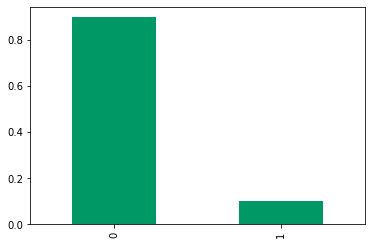

In [5]:
# Строим диаграмму распределения классов в целевом признаке
class_frequency = df_toxcom['toxic'].value_counts(normalize=True)
display(class_frequency)
class_frequency.plot(kind='bar', color='#009966')
plt.show()

<a id='the_part_1.4'></a>
### 1.4 Обработка пропущенных значений и дубликатов.

In [6]:
# Определим функцию анализа пропущенных данных
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total missing data', 'Percent missing data'])

# Выполним поиск пропущенных данных и дубликатов
display(missing_data(df_toxcom)) # поиск пропущенных данных
print('Дубликаты:', df_toxcom.duplicated().sum()) # поиск дубликатов

,Total missing data,Percent missing data
toxic,0,0.0
text,0,0.0


Дубликаты: 0


#### Выводы:

- Пропусков и дубликатов нет
- Наблюдается значительный дисбаланс классов в целевом признаке

[<span style="color:green"> К оглавлению</span>](#the_contents)

# 2. Обучение моделей

<a id='the_part_2.1'></a>
### 2.1 Лемматизация и подготовка данных для обучения.

In [7]:
%%time

# Создаем объект лемматизатора
lemmatizer = WordNetLemmatizer()

# Функция лемматизации
def lemmatize_text(text):
    tokens = word_tokenize(text) # Токенизация
    words_pnkt = (word for word in tokens if word.isalpha()) # Исключение знаков препинания
    words_lwr = (word.lower() for word in words_pnkt) # Перевод в нижний индекс
    stop_words = set(nltk_stopwords.words('english')) # Список английских стоп-слов
    words = (w for w in words_lwr if not w in stop_words) # Исключение стоп-слов
    return " ".join(lemmatizer.lemmatize(w) for w in words) # Лемматизация

# Добавление столбца лемматизированного текста
df_toxcom['text_lemmatized'] = df_toxcom['text'].apply(lemmatize_text)

Wall time: 5min 13s


In [8]:
# Формируем признаки, делим данные на обучающую и тестовую (20%) выборки 
features = df_toxcom['text_lemmatized']
target = df_toxcom['toxic']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=123, stratify=target)

#### Вычисление TF-IDF для корпуса текстов

In [9]:
# Выполняем векторизацию обучающей выборки
corpus = features_train.values.astype('U')
count_tf_idf = TfidfVectorizer()
count_tf_idf.fit(corpus)
features_train = count_tf_idf.transform(corpus)

# Смотрим на размер матрицы
print("Размер матрицы:", features_train.shape)

Размер матрицы: (127656, 128613)


In [10]:
# Выполняем векторизацию тестовой выборки
corpus = features_test.values.astype('U')
features_test = count_tf_idf.transform(corpus)

print("Размер матрицы:", features_test.shape)

Размер матрицы: (31915, 128613)


<a id='the_part_2.2'></a>
### 2.2 Линейный метод опорных векторов.

In [11]:
%%time
# Обучаем модель
model_lsvc = LinearSVC()
model_lsvc.fit(features_train, target_train)

Wall time: 2.09 s


LinearSVC()

In [12]:
# Предсказываем
predict_lsvc_train = model_lsvc.predict(features_train)
predict_lsvc = model_lsvc.predict(features_test)

# Смотрим метрику на обучающей и тестовой выборках
print('F1 обучающей выборки:', f1_score(target_train, predict_lsvc_train).round(3))
print('F1 тестовой выборки:', f1_score(target_test, predict_lsvc).round(3))

F1 обучающей выборки: 0.923
F1 тестовой выборки: 0.769


In [13]:
# Функция отображения распределение классов
def class_freq(data):
    class_frequency = pd.Series(data).value_counts(normalize=True)
    display(class_frequency)
    class_frequency.plot(kind='bar', color='#009966')
    plt.show()

0    0.920257
1    0.079743
dtype: float64

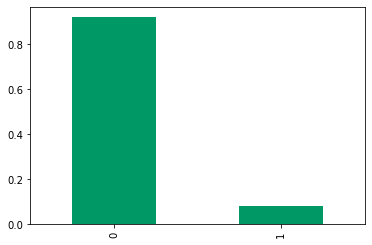

In [14]:
# Смотрим на распределение классов в предсказаниях
class_freq(predict_lsvc)

<a id='the_part_2.3'></a>
### 2.3 Логистическая регрессия.

In [15]:
%%time
# Обучаем модель
model_lr = LogisticRegression(random_state=123, solver='saga', class_weight='balanced', penalty='l2', tol=0.05) 
model_lr.fit(features_train, target_train)

Wall time: 9 s


LogisticRegression(class_weight='balanced', random_state=123, solver='saga',
                   tol=0.05)

In [16]:
# Предсказываем
predict_lr_train = model_lr.predict(features_train)
predict_lr = model_lr.predict(features_test)

# Смотрим метрику на обучающей и тестовой выборках
print('F1 обучающей выборки:', f1_score(target_train, predict_lr_train).round(3))
print('F1 тестовой выборки:', f1_score(target_test, predict_lr).round(3))

F1 обучающей выборки: 0.79
F1 тестовой выборки: 0.714


0    0.850822
1    0.149178
dtype: float64

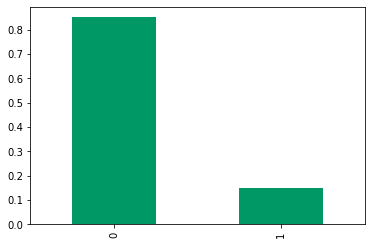

In [17]:
# Смотрим на распределение классов в предсказаниях
class_freq(predict_lr)

<a id='the_part_2.4'></a>
### 2.4 Линейная регрессия.

In [18]:
%%time
# Обучаем модель
model_lm = LinearRegression()
model_lm.fit(features_train, target_train)

Wall time: 21min 3s


LinearRegression()

In [19]:
# Предсказываем
predict_lm_train = model_lm.predict(features_train)
predict_lm = model_lm.predict(features_test)

# Смотрим метрику на обучающей и тестовой выборках
print('F1 обучающей выборки:', f1_score(target_train, (predict_lm_train > 0.5).astype(int)).round(3))
print('F1 тестовой выборки:', f1_score(target_test, (predict_lm > 0.5).astype(int)).round(3))

F1 обучающей выборки: 0.942
F1 тестовой выборки: 0.559


0    0.889049
1    0.110951
dtype: float64

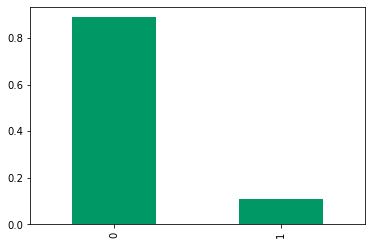

In [20]:
# Смотрим на распределение классов в предсказаниях
class_freq((predict_lm > 0.5).astype(int))

<a id='the_part_2.5'></a>
### 2.5 Модель BERT.

#### Скачаем в локальную папку предварительно загруженные на gdrive файлы обученной модели Conversational BERT, English, cased, 12-layer, 768-hidden, 12-heads, 110M parameters с сайта BERT in DeepPavlov http://docs.deeppavlov.ai/en/master/features/models/bert.html. 
(Раскомментировать код в ячейке ниже, если загрузка еще на была произведена.)

In [21]:
# Загрузка с гугл диска файлов vocab.txt, bert_config.json, pytorch_model.bin
# !gdown https://drive.google.com/uc?id=1IN_KIkWH_xSw9bOjcmSIIGFDQzWrUfg0
# !gdown https://drive.google.com/uc?id=11ylcySJCCuBUqhn_uXh-I_7PDB1UXwMF
# !gdown https://drive.google.com/uc?id=1z_GvdXvDnYpPpzDpU40OlM775KpiynlV

#### Исходный датасет очень большой, считается долго. Сформируем сбалансированный по целевым признакам датасет из 400 объектов с признаком токсичности 0 и 400 объектов с признаком токсичности 1.

In [22]:
# Выбираем объекты с признаком токсичности 0
df_toxcom_0 = df_toxcom[df_toxcom['toxic'] == 0].sample(n=400)

# Выбираем объекты с признаком токсичности 1
df_toxcom_1 = df_toxcom[df_toxcom['toxic'] == 1].sample(n=400)

# Объединяем и перемешиваем
df_toxcom = pd.concat([df_toxcom_0, df_toxcom_1]).sample(frac=1)

In [23]:
# Выполняем токенизацию с ограничением длины фразы в 512 слов
tokenizer = transformers.BertTokenizer(
    vocab_file='vocab.txt')

tokenized = df_toxcom['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [24]:
# Создаем модель BERT
config = transformers.BertConfig.from_json_file('bert_config.json')
model = transformers.BertModel.from_pretrained('pytorch_model.bin', config=config)

In [25]:
# Создаем эмбеддинги
batch_size = 20
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

In [26]:
# Формируем признаки для обучения
features = np.concatenate(embeddings)

# Делим на обучающую и тестовую выборки
target = df_toxcom['toxic']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.5, random_state=123, stratify=target)

#### Обучим модель логистической регрессии.

In [27]:
# Обучаем модель логистической регрессии
model_lr = LogisticRegression(random_state=123, solver='saga', class_weight='balanced', penalty='l2', tol=0.05) 
model_lr.fit(features_train, target_train)

LogisticRegression(class_weight='balanced', random_state=123, solver='saga',
                   tol=0.05)

In [28]:
# Печать метрики
print('F1 обучающей выборки:', f1_score(target_train, model_lr.predict(features_train)).round(3))
print('F1 тестовой выборки:', f1_score(target_test, model_lr.predict(features_test)).round(3))

F1 обучающей выборки: 0.935
F1 тестовой выборки: 0.861


[<span style="color:green"> К оглавлению</span>](#the_contents)

# 3. Выводы

<a id='the_part_3'></a>
### Выводы по исследованию.

1. Целевое значение 0,75 метрики F1 было достигнуто при векторизации текстов методом TF-IDF на модели линейного метода опорных векторов и составило 0,769.
2. При векторизации текстов методом TF-IDF модели логистической регрессии и линейной регрессии не достигли целевого значения F1, результат составил 0,714 и 0,559 соответственно.
3. В предсказаниях модели, достигшей целевого значения метрики (LinearSVC), количество объектов класса "0" больше, чем в тестовой выборке. В моделях, не достигших целевого значения метрики, таких объектов меньше, чем в тестовой выборке.
4. Применение модели BERT для кодирования текста поволило достичь на модели логистической регрессии на тестовой выборке F1 = 0,861.
5. Время обучения моделей на одном датасете может отличаться на несколько порядков, от единиц секунд до десятков часов.

[<span style="color:green"> К оглавлению</span>](#the_contents)

Использованные источники:

https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b

https://github.com/google-research/bert

http://docs.deeppavlov.ai/en/master/features/models/bert.html

https://github.com/huggingface/transformers/issues/1791

https://machinelearningmastery.com/clean-text-machine-learning-python/

https://pypi.org/project/pytorch-pretrained-bert/#notebooks